**Формулировка задачи**

Компания запустила новую функцию в мобильном приложении — персональные рекомендации товаров. Тебе нужно определить, повысила ли эта функция средний чек пользователей.

**Данные**

1) `user_id` - идентификатор пользователя
2) `date` - дата покупки
3) `revenue` - сумма покупки (в у.е.)
4) `group` - руппа пользователя: *control* (до внедрения) или *test* (после внедрения)

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

control_size = 1000
control_revenue = np.random.normal(loc=50, scale=15, size=control_size)  

control_df = pd.DataFrame({
    'user_id': range(1, control_size + 1),
    'date': pd.date_range(start="2024-01-01", periods=control_size, freq='D'),
    'revenue': control_revenue,
    'group': 'control'
})

test_size = 1000
test_revenue = np.random.normal(loc=55, scale=15, size=test_size)  

test_df = pd.DataFrame({
    'user_id': range(control_size + 1, control_size + test_size + 1),
    'date': pd.date_range(start="2024-02-01", periods=test_size, freq='D'),
    'revenue': test_revenue,
    'group': 'test'
})

df = pd.concat([control_df, test_df])
df.head()

,user_id,date,revenue,group
0,1,2024-01-01,57.450712,control
1,2,2024-01-02,47.926035,control
2,3,2024-01-03,59.715328,control
3,4,2024-01-04,72.845448,control
4,5,2024-01-05,46.487699,control


In [2]:
df.shape

(2000, 4)

**1. Проверить распределение среднего чека в контрольной и тестовой группах.**

In [6]:
control = df.query('group == "control"')
test = df.query('group == "test"')
control.head()

,user_id,date,revenue,group
0,1,2024-01-01,57.450712,control
1,2,2024-01-02,47.926035,control
2,3,2024-01-03,59.715328,control
3,4,2024-01-04,72.845448,control
4,5,2024-01-05,46.487699,control


In [8]:
test.head()

,user_id,date,revenue,group
0,1001,2024-02-01,75.990332,test
1,1002,2024-02-02,68.869505,test
2,1003,2024-02-03,55.894456,test
3,1004,2024-02-04,45.295948,test
4,1005,2024-02-05,65.473350,test


In [10]:
control_mean = control.revenue.mean()
test_mean = test.revenue.mean()
control_std = control.revenue.std()
test_std = test.revenue.std()
print(f'control_mean = {round(control_mean, 2)}, control_std = {round(control_std, 2)}')
print(f'test_mean = {round(test_mean, 2)}, test_std = {round(test_std, 2)}')

control_mean = 50.29, control_std = 14.69
test_mean = 56.06, test_std = 14.96


Text(0.5, 1.0, 'Распределение исходов для контрольной группы')

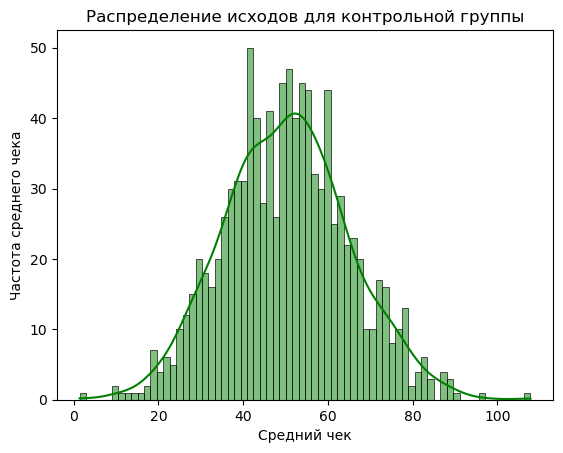

In [12]:
sns.histplot(control.revenue, bins=70, kde=True, color='green')
plt.xlabel('Средний чек')
plt.ylabel('Частота среднего чека')
plt.title('Распределение исходов для контрольной группы')

Text(0.5, 1.0, 'Распределение исходов для тестовой группы')

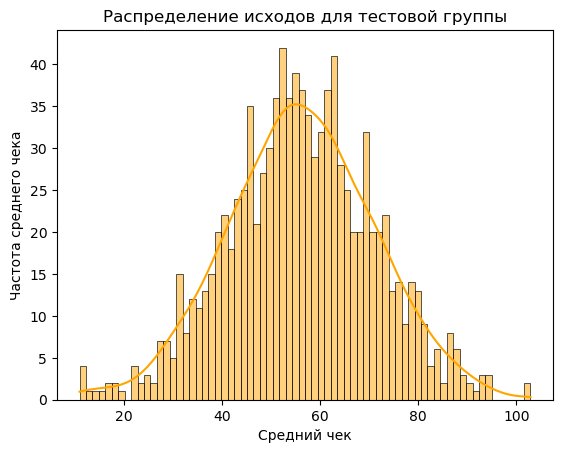

In [14]:
sns.histplot(test.revenue, bins=70, kde=True, color='orange')
plt.xlabel('Средний чек')
plt.ylabel('Частота среднего чека')
plt.title('Распределение исходов для тестовой группы')

**2. Оценить нормальность распределения**

In [17]:
from scipy.stats import kstest, shapiro
pvalue_shapiro_control = shapiro(control.revenue).pvalue
pvalue_shapiro_test = shapiro(test.revenue).pvalue
pvalue_kstest_control = kstest(control.revenue, cdf='norm').pvalue
pvalue_kstest_test = kstest(list(test.revenue), cdf='norm').pvalue
print(f'All p-value: {pvalue_kstest_control, pvalue_kstest_test} - kstest, {pvalue_shapiro_control, pvalue_shapiro_test} - shapiro-wilk')

All p-value: (0.0, 0.0) - kstest, (0.627257829024364, 0.7311929770362118) - shapiro-wilk


In [19]:
def qqplot(sample, name_of_sample):
    sample.sort()
    sample_quantiles = sample[0:-1]
    N = len(sample)
    x = [i/N for i in range(1, N)]
    theoretical_quantiles = norm().ppf(x)
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1,1,1)
    ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth='1.0', color='red')
    plt.title(f'This is {name_of_sample} sample')

/var/folders/jm/lyl2x71d4p3019zwc7l2sdm40000gn/T/ipykernel_5770/4208566636.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  ax.plot(theoretical_quantiles, sample_quantiles, 'k.', linewidth='1.0', color='red')


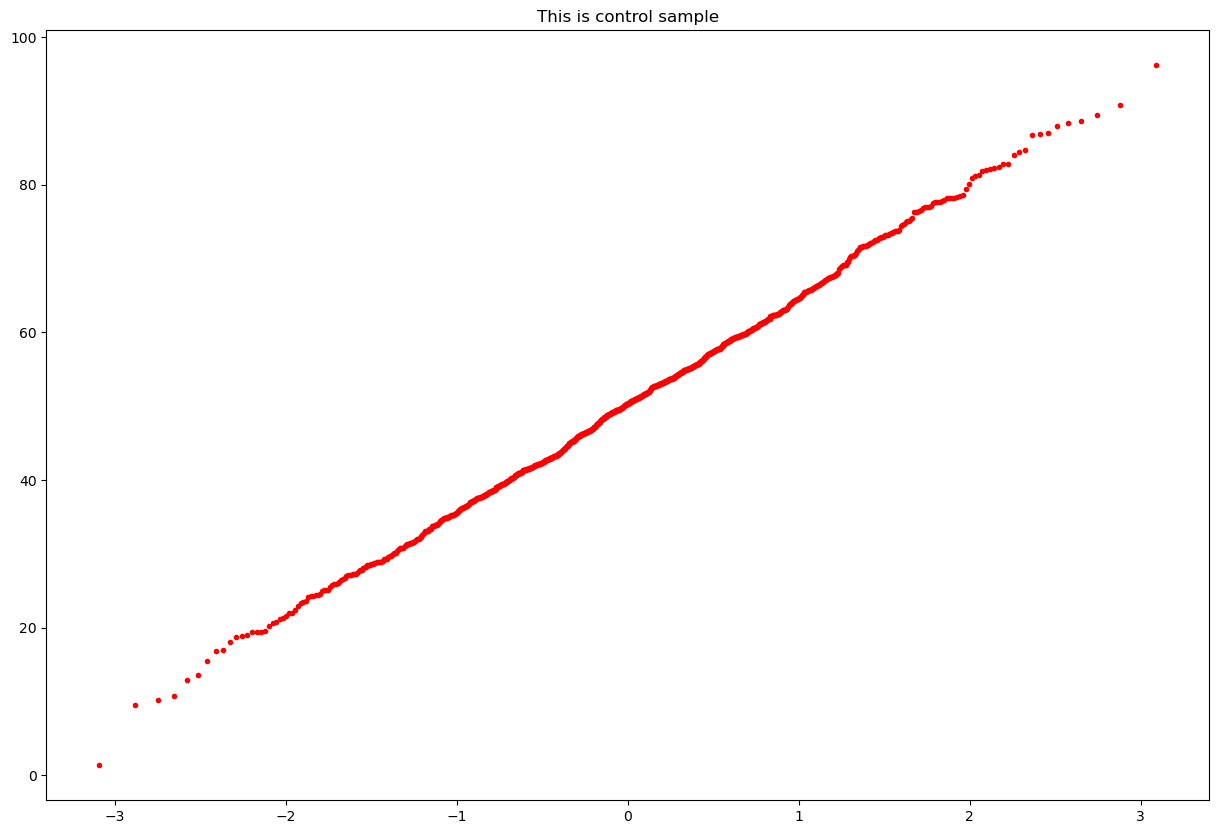

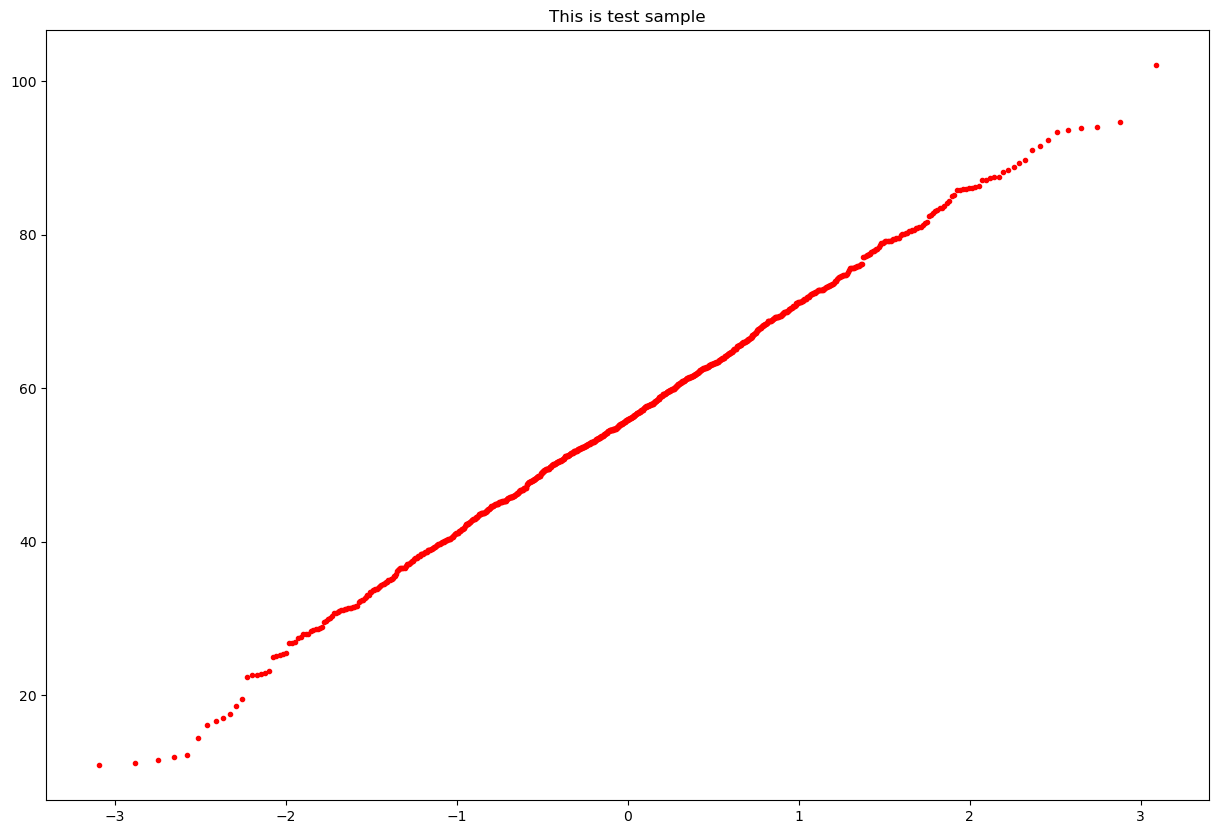

In [21]:
from scipy.stats import norm
sample_control = list(control.revenue)
sample_test = list(test.revenue)
qqplot(sample_control, 'control')
qqplot(sample_test, 'test')

Из теста `Шапиро-Уилка`, `Колмогорова-Смирнова` и графика `QQ-plot` мы можем сделать вывод, что распределение контрольной и тестовой группы - `нормальное`, также мы можем сделать этот вывод исходя из `Центральной Предельной Теоремы (ЦПТ)`, так как количество элементов в каждой группе - 1000. Следовательно, это дает нам право применить `критерий Стьюдента` в следующем шаге

**3. Использовать t-test или U-test для проверки значимости различий**

In [36]:
from scipy.stats import ttest_ind
ttest_ind(control.revenue, test.revenue)

TtestResult(statistic=-8.706421184453966, pvalue=6.441697673782856e-18, df=1998.0)

**4.Вывод** 

Так как p-value после проведения нашего теста оказался **довольно маленьким**, значит мы делаем вывод, что статистически (на уровне значимости alpha=0.05) эти выборки довольно сильно отличаются друг от друга. Среднее тестовой выборки выше, чем контрольной, значит мы делаем вывод, что после внедрения персональных рекомендаций средний чек стал выше, значит это **изменение повлияло на нашу бизнес-модуль**